In [1]:
import os
import torch
import random
import pickle
import numpy as np
import scanpy as sc

import NEXUS
from NEXUS.data_process.data_process_sample import creat_adata_graph, Adata_to_graph, creat_graph_adata 
from NEXUS.sample_emb.Graph_model import GraphVAE, train_model, embedding, loss_function

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [2]:
random_seed = 42
input_path = "../test_data/1_cell_emb_output/VAE_embedded.h5ad"
output_path = "../test_data/2_graph_emb_output/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

sample_col = 'sample_ID' #sample
cluster_col = ['sample_cluster']  #sample label

pooling_type = 'mean'
split_ratio = 0.9
batch_size = 10
input_dim = 64
hidden_dim = 64
latent_dim = 32
heads = 2
edge_dims = 1 

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

In [3]:
adata = sc.read_h5ad(input_path)
adata, class_num = creat_adata_graph(adata, sample_col, cluster_col)

In [4]:
adata_to_graph = Adata_to_graph(adata, split_ratio, batch_size)
adata = adata_to_graph.label_meta()
adata_to_graph.get_graph_dataset()
graph_dataset, train_loader, test_loader = adata_to_graph.dataloader()
adata.write(output_path + 'cell_embedded_adata.h5ad')

In [5]:
model = GraphVAE(input_dim, hidden_dim, latent_dim, class_num, pooling_type = pooling_type, heads = heads, edge_dims = edge_dims)
model = model.to(device)

In [6]:
train_model(model, train_loader, test_loader, loss_function, fine_tune=False, device = device)
del train_loader, test_loader

Epoch 1/500, Train Loss: 2.3845, Train Acc: 0.5385
Contrastive Loss: 1.3861, Edge Prediction Loss: 1.8401
Test Loss: 0.7990, Test Acc: 0.0000
Epoch 2/500, Train Loss: 2.3325, Train Acc: 0.3846
Contrastive Loss: 1.3656, Edge Prediction Loss: 1.7262
Test Loss: 0.7695, Test Acc: 0.0000
Epoch 3/500, Train Loss: 2.2375, Train Acc: 0.3846
Contrastive Loss: 1.1663, Edge Prediction Loss: 1.6276
Test Loss: 0.7034, Test Acc: 0.0000
Epoch 4/500, Train Loss: 2.1926, Train Acc: 0.3846
Contrastive Loss: 1.2976, Edge Prediction Loss: 1.5016
Test Loss: 0.6501, Test Acc: 0.0000
Epoch 5/500, Train Loss: 2.1323, Train Acc: 0.4615
Contrastive Loss: 1.2862, Edge Prediction Loss: 1.9681
Test Loss: 0.5965, Test Acc: 0.0000
Epoch 6/500, Train Loss: 2.0496, Train Acc: 0.3846
Contrastive Loss: 1.3383, Edge Prediction Loss: 1.4873
Test Loss: 0.5229, Test Acc: 0.0000
Epoch 7/500, Train Loss: 1.8751, Train Acc: 0.3846
Contrastive Loss: 0.9882, Edge Prediction Loss: 1.4022
Test Loss: 0.4433, Test Acc: 0.0000
Epoch 

In [7]:
embedded_dataset = embedding(model, graph_dataset, device = device)

In [8]:
with open(output_path + "Graph_embedded.pickle", "wb") as file:
    pickle.dump(embedded_dataset, file)

model = model.to('cpu')
torch.save(model, output_path + "Graph_VAE_model.pt")

### 构建 graph_adata

In [9]:
strong = False
meta_label = []
file_path = "../test_data/2_graph_emb_output/"

In [10]:
adata = creat_graph_adata(file_path, meta_label, strong)

F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata.write(file_path + 'graph_embedded_adata.h5ad')

In [12]:
import scanpy as sc
import NEXUS
from NEXUS.plotting.emb_plot import sample_embedding_umap_plot

In [13]:
adata = sc.read_h5ad("../test_data/2_graph_emb_output/graph_embedded_adata.h5ad")

In [14]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)

In [15]:
sc.pp.neighbors(adata, n_neighbors = 5, use_rep="X_pca")
sc.tl.umap(adata)

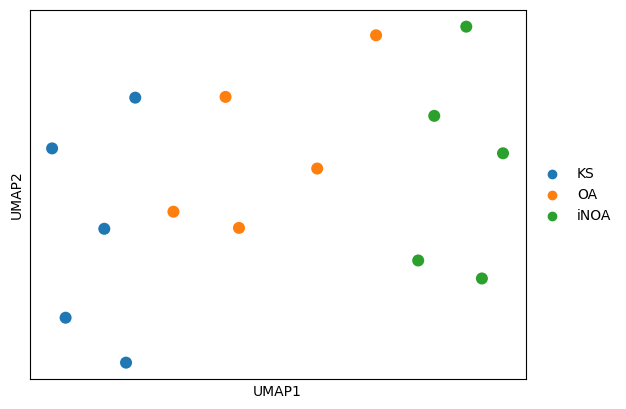

In [16]:
sc.pl.umap(adata, color = "cluster", size = 300, title=""
          )